### Import TensorFlow

In [1]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
import numpy as np
import math

### Download and prepare the CIFAR10 dataset


The CIFAR10 dataset contains 60,000 color images in 10 classes, with 6,000 images in each class. The dataset is divided into 50,000 training images and 10,000 testing images. The classes are mutually exclusive and there is no overlap between them.

In [2]:
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()

# Normalize pixel values to be between 0 and 1
train_images, test_images = train_images / 255.0, test_images / 255.0

In [6]:
test_labels[0:10]

array([[3],
       [8],
       [8],
       [0],
       [6],
       [6],
       [1],
       [6],
       [3],
       [1]], dtype=uint8)

### Verify the data

To verify that the dataset looks correct, let's plot the first 25 images from the training set and display the class name below each image:


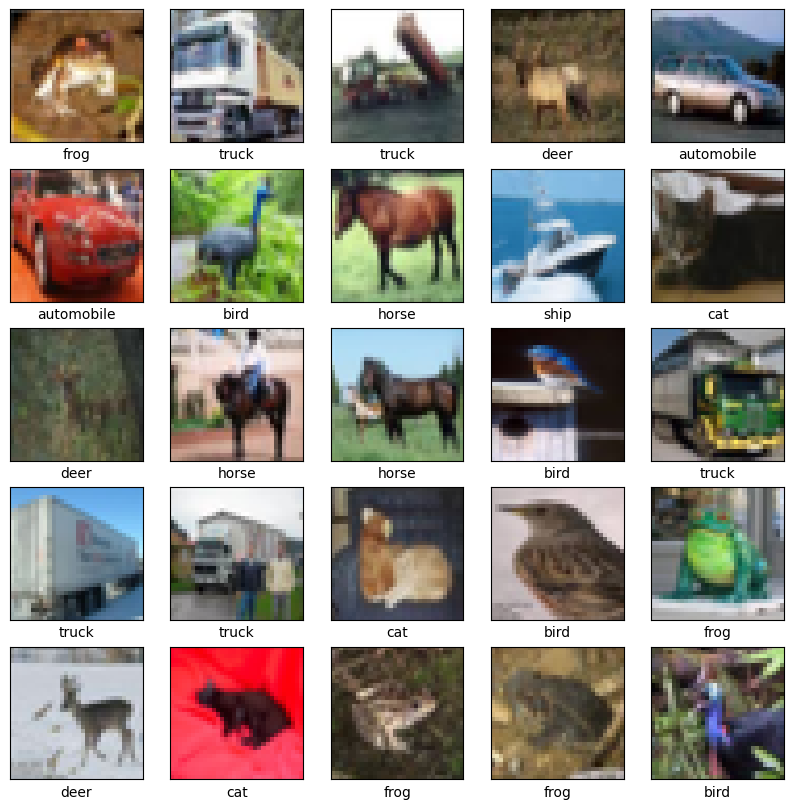

In [3]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i])
    # The CIFAR labels happen to be arrays,
    # which is why you need the extra index
    plt.xlabel(class_names[train_labels[i][0]])
plt.show()

### Create the convolutional base

The 6 lines of code below define the convolutional base using a common pattern: a stack of [Conv2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D) and [MaxPooling2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/MaxPool2D) layers.

As input, a CNN takes tensors of shape (image_height, image_width, color_channels), ignoring the batch size. If you are new to these dimensions, color_channels refers to (R,G,B). In this example, you will configure your CNN to process inputs of shape (32, 32, 3), which is the format of CIFAR images. You can do this by passing the argument `input_shape` to your first layer.


In [7]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10))

c:\Users\amirifam\AppData\Local\miniforge3\envs\exp_env\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Let's display the architecture of your model so far:

In [8]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 30, 30, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 13, 13, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 4, 4, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │        65,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 122,570 (478.79 KB)

 Trainable params: 122,570 (478.79 KB)

 Non-trainable params: 0 (0.00 B)

Above, you can see that the output of every Conv2D and MaxPooling2D layer is a 3D tensor of shape (height, width, channels). The width and height dimensions tend to shrink as you go deeper in the network. The number of output channels for each Conv2D layer is controlled by the first argument (e.g., 32 or 64). Typically,  as the width and height shrink, you can afford (computationally) to add more output channels in each Conv2D layer.

The network summary shows that (4, 4, 64) outputs were flattened into vectors of shape (1024) before going through two Dense layers.

# Get filters from layers

In [6]:
def get_filters(model)->dict:
    """
    Take the model and give filters for layers
    Args: 
        model

    Returns:
        dict : A dictionary which includes filters for different layers

    """
    filters_dict = {}
    for index, layer in enumerate(model.layers):
        try :
            filter_wights, biases = layer.get_weights()[0], layer.get_weights()[1]
            print(f"Layer Number: {index+1}")
            print(f"Layer_Name: {layer.name}")
            print(f"filter_wights: {filter_wights.shape}")
            print(f"biases: {biases.shape}")
            filters_dict[layer.name] = [filter_wights,biases]
        except:
            print(f"Layer Number: {index+1}")
            print(f"Layer_Name: {layer.name}")
            print("Had No weights")
            pass
        print("*"*100)

    return filters_dict

In [7]:

not_trained_filters_dict = get_filters(model)


Layer Number: 1
Layer_Name: conv2d
filter_wights: (3, 3, 3, 32)
biases: (32,)
****************************************************************************************************
Layer Number: 2
Layer_Name: max_pooling2d
Had No weights
****************************************************************************************************
Layer Number: 3
Layer_Name: conv2d_1
filter_wights: (3, 3, 32, 64)
biases: (64,)
****************************************************************************************************
Layer Number: 4
Layer_Name: max_pooling2d_1
Had No weights
****************************************************************************************************
Layer Number: 5
Layer_Name: conv2d_2
filter_wights: (3, 3, 64, 64)
biases: (64,)
****************************************************************************************************
Layer Number: 6
Layer_Name: flatten
Had No weights
****************************************************************************************

# Get feature maps

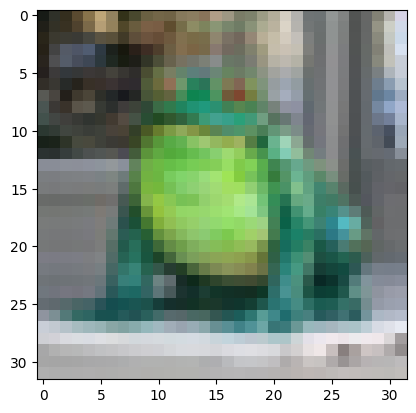

In [8]:
# Define an example as input
test_input = train_images[19]
plt.imshow(test_input)
test_input = np.expand_dims(test_input, axis=0)


In [9]:

def get_feature_maps(model):
    global test_input
    feature_maps_dict = {}
    for index in  range(len(model.layers)):
        name = model.layers[index].name
        new_model = Model(inputs=model.inputs, outputs=model.layers[index].output)
        feature_maps = new_model.predict(test_input)
        feature_maps_dict[name] = feature_maps

    return feature_maps_dict
    



In [10]:
not_trained_feature_mpas_dict = get_feature_maps(model)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


# Visualize feature_maps

In [11]:
for key, value in not_trained_feature_mpas_dict.items():
    print(f"Layer[{key}]: shape {value.shape}")

Layer[conv2d]: shape (1, 30, 30, 32)
Layer[max_pooling2d]: shape (1, 15, 15, 32)
Layer[conv2d_1]: shape (1, 13, 13, 64)
Layer[max_pooling2d_1]: shape (1, 6, 6, 64)
Layer[conv2d_2]: shape (1, 4, 4, 64)
Layer[flatten]: shape (1, 1024)
Layer[dense]: shape (1, 64)
Layer[dense_1]: shape (1, 10)


In [ ]:
def plot_filter_maps(feture_maps_dict,layer_name):

    num_images = feture_maps_dict[layer_name].shape[-1]
    # Calculate number of rows needed to fit all images
    cols = 8
    rows = math.ceil(num_images / cols)
    
    ix = 1
    feature_maps = feture_maps_dict[layer_name]
    plt.figure(figsize=(15, 15))
    
    for _ in range(rows):
        for _ in range(cols):
            if ix > num_images:
                break  # Stop if we reached the number of images
    
            # Specify subplot and turn off axis
            ax = plt.subplot(rows, cols, ix)
            ax.set_xticks([])
            ax.set_yticks([])
    
            # Plot filter channel in grayscale
            plt.imshow(feature_maps[0, :, :, ix - 1], cmap='gray')
    
            ix += 1
    
    # Adjust layout to prevent overlap
    plt.tight_layout()
    
    # Show the figure
    plt.show()

In [ ]:
plot_filter_maps(feture_maps_dict=not_trained_feature_mpas_dict,layer_name='conv2d')

### Compile and train the model

In [12]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(train_images, train_labels, epochs=10,
                    validation_data=(test_images, test_labels))
model.save('simple_cnn.h5')

Epoch 1/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 21s 12ms/step - accuracy: 0.3503 - loss: 1.7553 - val_accuracy: 0.5542 - val_loss: 1.2492
Epoch 2/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 30s 19ms/step - accuracy: 0.5602 - loss: 1.2322 - val_accuracy: 0.5960 - val_loss: 1.1581
Epoch 3/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 36s 16ms/step - accuracy: 0.6336 - loss: 1.0487 - val_accuracy: 0.6555 - val_loss: 0.9876
Epoch 4/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 25s 16ms/step - accuracy: 0.6736 - loss: 0.9280 - val_accuracy: 0.6785 - val_loss: 0.9134
Epoch 5/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 28s 18ms/step - accuracy: 0.7065 - loss: 0.8393 - val_accuracy: 0.6629 - val_loss: 0.9684
Epoch 6/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 28s 18ms/step - accuracy: 0.7267 - loss: 0.7774 - val_accuracy: 0.6888 - val_loss: 0.8981
Epoch 7/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 28s 18ms/step - accuracy: 0.7454 - loss: 0.7288 - val_accuracy: 0.7029 - val_loss: 0.8647
Epoch 8/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 28s 18ms/step - accuracy: 0.7643 -

In [13]:
trained_filters_dict =get_filters(model)
trained_feature_maps_dict = get_feature_maps(model)

Layer Number: 1
Layer_Name: conv2d
filter_wights: (3, 3, 3, 32)
biases: (32,)
****************************************************************************************************
Layer Number: 2
Layer_Name: max_pooling2d
Had No weights
****************************************************************************************************
Layer Number: 3
Layer_Name: conv2d_1
filter_wights: (3, 3, 32, 64)
biases: (64,)
****************************************************************************************************
Layer Number: 4
Layer_Name: max_pooling2d_1
Had No weights
****************************************************************************************************
Layer Number: 5
Layer_Name: conv2d_2
filter_wights: (3, 3, 64, 64)
biases: (64,)
****************************************************************************************************
Layer Number: 6
Layer_Name: flatten
Had No weights
****************************************************************************************

# Calculate_Expressivity_score

In [14]:
def calculate_exp_score(feature_maps_dict, constant=1e-7):
    layers_name_list = feature_maps_dict.keys()
    exp_score_dict = {}
    pca_var_dict = {}
    model_exp_score_sum = 0


    for layer in layers_name_list:
        try:
            # Get feature map: shape (b, w, h, c)
            fmap = feature_maps_dict[layer]
            
            # Convert to TensorFlow tensor if it's not already
            if not isinstance(fmap, tf.Tensor):
                fmap = tf.convert_to_tensor(fmap, dtype=tf.float32)
            
            b, w, h, c = fmap.shape
            print(b, w, h, c)
            
            # Reshape to (b*w*h, c)
            feat = tf.reshape(fmap, (b * w * h, c))
            print('feat',feat.shape)
            # Mean over rows (dim=0), keep dims for broadcasting
            mean = tf.reduce_mean(feat, axis=0, keepdims=True)
            print('mean',mean.shape)
            
            # Center the features
            feat_centered = feat - mean  # shape (b*w*h, c)
            
            # Covariance matrix: (c, c)
            Covariance_matrix = tf.matmul(feat_centered, feat_centered, transpose_a=True) / tf.cast(tf.shape(feat_centered)[0], tf.float32)
            print('Covariance_matrix',Covariance_matrix.shape)
            # Compute eigenvalues (TensorFlow 2.4+)
            eigenvalues = tf.linalg.eigvalsh(Covariance_matrix)
            print('eigenvalues',eigenvalues.shape)
            

        
            eigenvalues1 = tf.linalg.eigvalsh(Covariance_matrix)
            explained_variance = eigenvalues1 / tf.reduce_sum(eigenvalues1)
            explained_variance = tf.reverse(explained_variance, axis=[0])  # descending order
            pca_var_dict[layer]=explained_variance
    
            # Normalize eigenvalues to get probabilities
            prob_s = eigenvalues / tf.reduce_sum(eigenvalues)
            
            # Calculate score = -prob_s * log(prob_s + constant)
            score = -prob_s * tf.math.log(prob_s + constant)
            
            # Sum scores to get expressivity score
            expressivity_score = tf.reduce_sum(score).numpy().item()
            
            exp_score_dict[layer] = expressivity_score
            model_exp_score_sum += expressivity_score
            
            print(f'The score of Layer {layer} was added to the list')
            print("*"*100)
            
        except Exception as e:
            print(f'Error: The score of Layer {layer} was not added to the list. Exception: {e}')
            print("*"*100)
    return exp_score_dict, pca_var_dict, model_exp_score_sum

In [15]:
not_trained_exp_score_dict, not_trained_pca_dict, not_train_model_exp_score= calculate_exp_score(feature_maps_dict=not_trained_feature_mpas_dict,constant=1e-7)



1 30 30 32
feat (900, 32)
mean (1, 32)
Covariance_matrix (32, 32)
eigenvalues (32,)
The score of Layer conv2d was added to the list
****************************************************************************************************
1 15 15 32
feat (225, 32)
mean (1, 32)
Covariance_matrix (32, 32)
eigenvalues (32,)
The score of Layer max_pooling2d was added to the list
****************************************************************************************************
1 13 13 64
feat (169, 64)
mean (1, 64)
Covariance_matrix (64, 64)
eigenvalues (64,)
The score of Layer conv2d_1 was added to the list
****************************************************************************************************
1 6 6 64
feat (36, 64)
mean (1, 64)
Covariance_matrix (64, 64)
eigenvalues (64,)
The score of Layer max_pooling2d_1 was added to the list
****************************************************************************************************
1 4 4 64
feat (16, 64)
mean (1, 64)
Covariance_matrix

In [16]:
for key in not_trained_exp_score_dict.keys():
    print(f"Layer [{key}]: Expressivity_score[{not_trained_exp_score_dict[key]}]")

print(f"total score: {not_train_model_exp_score}")

Layer [conv2d]: Expressivity_score[1.2590917348861694]
Layer [max_pooling2d]: Expressivity_score[1.3289698362350464]
Layer [conv2d_1]: Expressivity_score[2.0708556175231934]
Layer [max_pooling2d_1]: Expressivity_score[2.002983570098877]
Layer [conv2d_2]: Expressivity_score[1.9715083837509155]
total score: 8.633409142494202


In [17]:

for key in not_trained_pca_dict.keys():
    print(f"Layer [{key}]: Pca_shape[{not_trained_pca_dict[key].shape}]")


Layer [conv2d]: Pca_shape[(32,)]
Layer [max_pooling2d]: Pca_shape[(32,)]
Layer [conv2d_1]: Pca_shape[(64,)]
Layer [max_pooling2d_1]: Pca_shape[(64,)]
Layer [conv2d_2]: Pca_shape[(64,)]


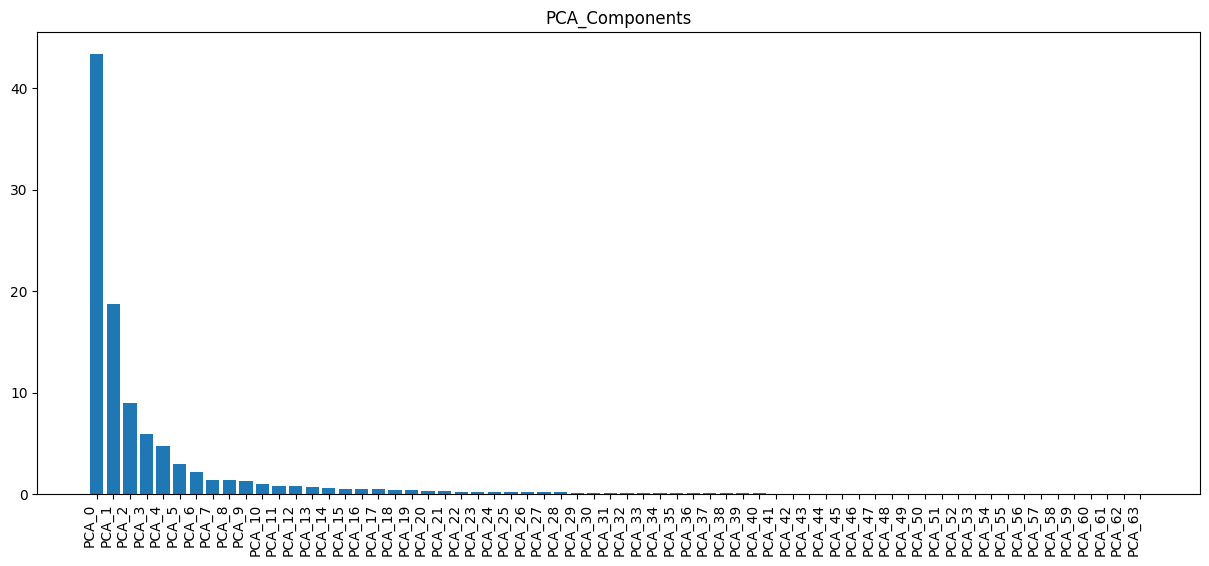

In [27]:
plt.figure(figsize=(15, 6))
states = [ f"PCA_{i}" for i in range(not_trained_pca_dict['conv2d_1'].numpy().shape[0])]
not_trained_values = not_trained_pca_dict['conv2d_1'].numpy()
plt.bar(states, not_trained_values*100)
plt.title("PCA_Components")
plt.xticks(rotation=90, ha='right')
plt.show()

In [22]:
trained_exp_score_dict, trained_pca_dict, trained_model_exp_score= calculate_exp_score(feature_maps_dict=trained_feature_maps_dict,constant=1e-7)


1 30 30 32
feat (900, 32)
mean (1, 32)
Covariance_matrix (32, 32)
eigenvalues (32,)
The score of Layer conv2d was added to the list
****************************************************************************************************
1 15 15 32
feat (225, 32)
mean (1, 32)
Covariance_matrix (32, 32)
eigenvalues (32,)
The score of Layer max_pooling2d was added to the list
****************************************************************************************************
1 13 13 64
feat (169, 64)
mean (1, 64)
Covariance_matrix (64, 64)
eigenvalues (64,)
The score of Layer conv2d_1 was added to the list
****************************************************************************************************
1 6 6 64
feat (36, 64)
mean (1, 64)
Covariance_matrix (64, 64)
eigenvalues (64,)
The score of Layer max_pooling2d_1 was added to the list
****************************************************************************************************
1 4 4 64
feat (16, 64)
mean (1, 64)
Covariance_matrix

In [23]:
for key in trained_exp_score_dict.keys():
    print(f"Layer [{key}]: Expressivity_score[{trained_exp_score_dict[key]}]")

print(f"total score: {trained_model_exp_score}")

Layer [conv2d]: Expressivity_score[2.1820197105407715]
Layer [max_pooling2d]: Expressivity_score[2.083841562271118]
Layer [conv2d_1]: Expressivity_score[2.6223230361938477]
Layer [max_pooling2d_1]: Expressivity_score[2.4013404846191406]
Layer [conv2d_2]: Expressivity_score[1.7682037353515625]
total score: 11.05772852897644


In [24]:
for key in trained_pca_dict.keys():
    print(f"Layer [{key}]: Pca_shape[{trained_pca_dict[key].shape}]")


Layer [conv2d]: Pca_shape[(32,)]
Layer [max_pooling2d]: Pca_shape[(32,)]
Layer [conv2d_1]: Pca_shape[(64,)]
Layer [max_pooling2d_1]: Pca_shape[(64,)]
Layer [conv2d_2]: Pca_shape[(64,)]


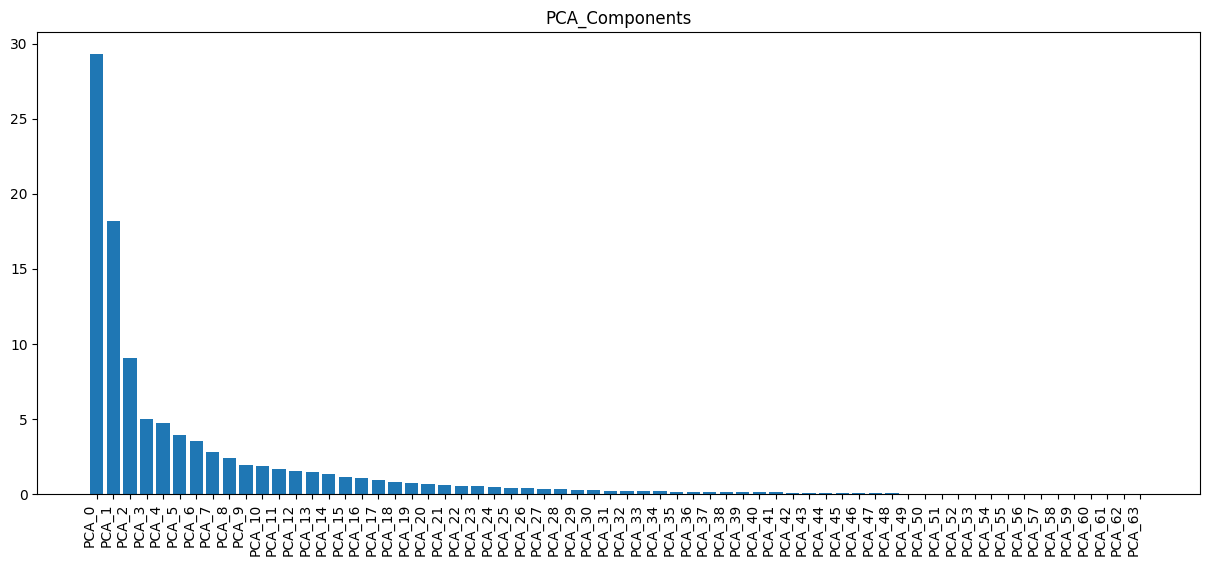

In [26]:
plt.figure(figsize=(15, 6))
states = [ f"PCA_{i}" for i in range(trained_pca_dict['conv2d_1'].numpy().shape[0])]
trained_values = trained_pca_dict['conv2d_1'].numpy()
plt.bar(states, trained_values*100)
plt.title("PCA_Components")
plt.xticks(rotation=90, ha='right')
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(15, 6))

bars1 = ax.bar(states, not_trained_values*100, label='Not Trained', width=0.4, align='edge', alpha=0.7)
bars2 = ax.bar(states, trained_values*100, label='Trained', width=0.4, align='center', alpha=0.7)

ax.set_xticks(range(len(states)))
ax.set_xticklabels(states, rotation=90, ha='right')
ax.set_ylabel('Values')
ax.set_title('Side-by-side Bar Chart')
ax.legend()


plt.show()

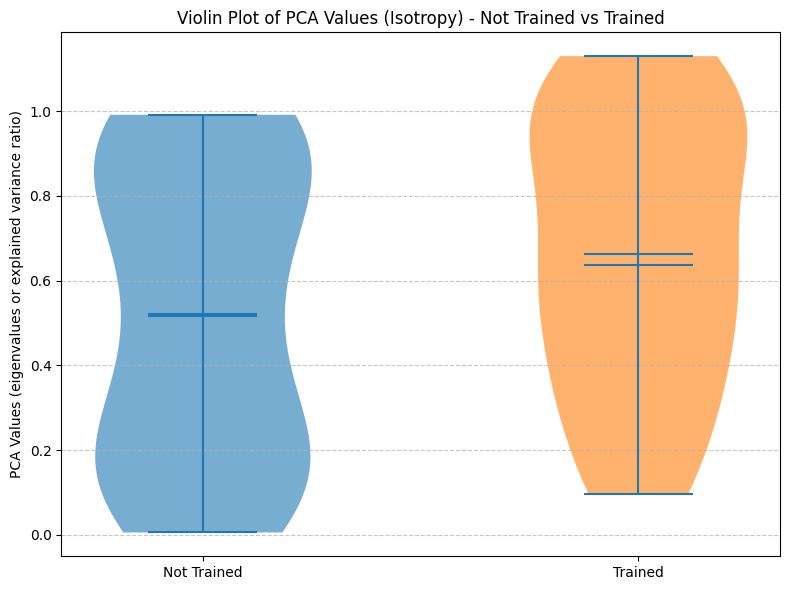

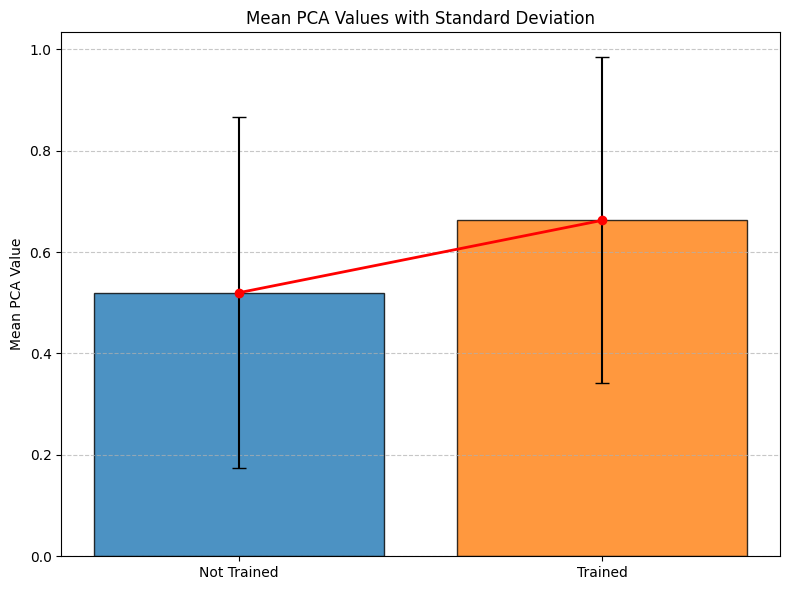

In [45]:
# Example PCA values (eigenvalues or explained variance ratios) for Not Trained and Trained
# Replace these with your actual PCA data arrays (1D arrays of PCA values)
not_trained_values = np.random.rand(30)
trained_values = np.random.rand(30) * 1.2  # scaled for example

states = ['Not Trained', 'Trained']

# Violin plot with boxplot inside
plt.figure(figsize=(8, 6))
parts = plt.violinplot([not_trained_values, trained_values], showmeans=True, showmedians=True, showextrema=True)

# Customize colors
colors = ['#1f77b4', '#ff7f0e']  # blue, orange
for i, pc in enumerate(parts['bodies']):
    pc.set_facecolor(colors[i])
    pc.set_alpha(0.6)

plt.xticks([1, 2], states)
plt.title('Violin Plot of PCA Values (Isotropy) - Not Trained vs Trained')
plt.ylabel('PCA Values (eigenvalues or explained variance ratio)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Bar + Line plot for mean PCA values per state
mean_values = [np.mean(not_trained_values), np.mean(trained_values)]
std_values = [np.std(not_trained_values), np.std(trained_values)]

fig, ax = plt.subplots(figsize=(8, 6))
bars = ax.bar(states, mean_values, yerr=std_values, color=colors, edgecolor='black', capsize=5, alpha=0.8)

# Plot mean points connected by line
ax.plot(states, mean_values, color='red', linewidth=2, marker='o')

ax.set_ylabel('Mean PCA Value')
ax.set_title('Mean PCA Values with Standard Deviation')
ax.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

C:\Users\amirifam\AppData\Local\Temp\ipykernel_4360\2073783689.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='State', y='PCA Value', data=data, palette=['#1f77b4', '#ff7f0e'], showfliers=False)


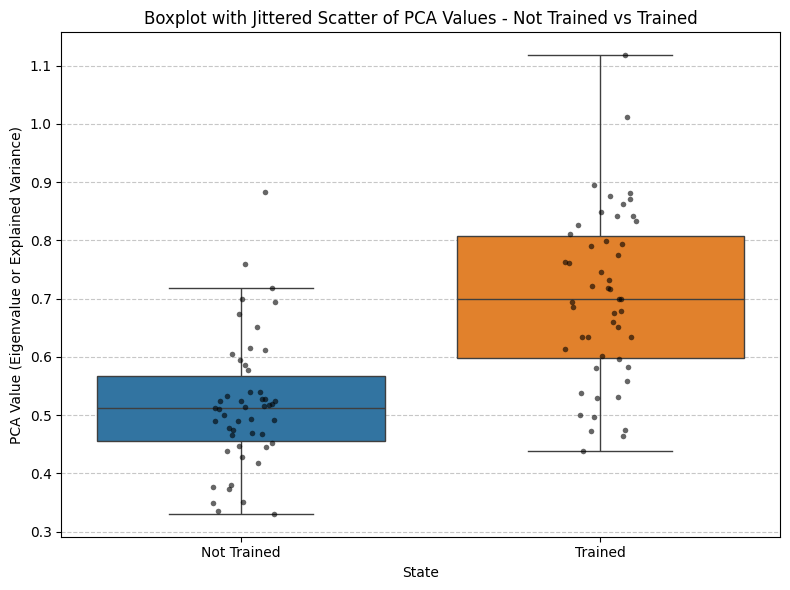

In [46]:
import seaborn as sns
import pandas as pd

# Example PCA values for Not Trained and Trained (replace with your data)
not_trained_values = np.random.normal(loc=0.5, scale=0.1, size=50)
trained_values = np.random.normal(loc=0.7, scale=0.15, size=50)

# Prepare data for seaborn
data = pd.DataFrame({
    'PCA Value': np.concatenate([not_trained_values, trained_values]),
    'State': ['Not Trained']*len(not_trained_values) + ['Trained']*len(trained_values)
})

plt.figure(figsize=(8, 6))

# Boxplot with jittered scatter points
sns.boxplot(x='State', y='PCA Value', data=data, palette=['#1f77b4', '#ff7f0e'], showfliers=False)
sns.stripplot(x='State', y='PCA Value', data=data, color='black', size=4, jitter=True, alpha=0.6)

plt.title('Boxplot with Jittered Scatter of PCA Values - Not Trained vs Trained')
plt.ylabel('PCA Value (Eigenvalue or Explained Variance)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Model 2

In [47]:
from tensorflow.keras import layers, models, regularizers, initializers

In [50]:


model = models.Sequential()

# Block 1
model.add(layers.Conv2D(32, (3, 3), padding='same', kernel_initializer='he_normal',
                        activation='relu', input_shape=(32, 32, 3)))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.25))

# Block 2
model.add(layers.Conv2D(64, (3, 3), padding='same', kernel_initializer='he_normal', activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.25))

# Block 3
model.add(layers.Conv2D(128, (3, 3), padding='same', kernel_initializer='he_normal', activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.25))

# Global Average Pooling instead of Flatten
model.add(layers.GlobalAveragePooling2D())

# Fully connected layer
model.add(layers.Dense(128, activation='relu', kernel_initializer='he_normal'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.5))

# Output layer with softmax activation for classification
model.add(layers.Dense(10))

c:\Users\amirifam\AppData\Local\miniforge3\envs\exp_env\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [49]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 112,458 (439.29 KB)

 Trainable params: 111,754 (436.54 KB)

 Non-trainable params: 704 (2.75 KB)

In [51]:
not_trained_filters_dict = get_filters(model)

Layer Number: 1
Layer_Name: conv2d_6
filter_wights: (3, 3, 3, 32)
biases: (32,)
****************************************************************************************************
Layer Number: 2
Layer_Name: batch_normalization_4
filter_wights: (32,)
biases: (32,)
****************************************************************************************************
Layer Number: 3
Layer_Name: max_pooling2d_5
Had No weights
****************************************************************************************************
Layer Number: 4
Layer_Name: dropout_4
Had No weights
****************************************************************************************************
Layer Number: 5
Layer_Name: conv2d_7
filter_wights: (3, 3, 32, 64)
biases: (64,)
****************************************************************************************************
Layer Number: 6
Layer_Name: batch_normalization_5
filter_wights: (64,)
biases: (64,)
****************************************************

In [52]:
not_trained_feature_mpas_dict = get_feature_maps(model)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


In [53]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(train_images, train_labels, epochs=10,
                    validation_data=(test_images, test_labels))
model.save('simple_cnn.h5')

Epoch 1/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 69s 42ms/step - accuracy: 0.3042 - loss: 2.0819 - val_accuracy: 0.4533 - val_loss: 1.4731
Epoch 2/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 84s 54ms/step - accuracy: 0.4933 - loss: 1.3953 - val_accuracy: 0.5716 - val_loss: 1.1811
Epoch 3/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 75s 48ms/step - accuracy: 0.5584 - loss: 1.2325 - val_accuracy: 0.5566 - val_loss: 1.2371
Epoch 4/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 87s 56ms/step - accuracy: 0.5917 - loss: 1.1434 - val_accuracy: 0.6105 - val_loss: 1.0963
Epoch 5/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 88s 56ms/step - accuracy: 0.6227 - loss: 1.0661 - val_accuracy: 0.6107 - val_loss: 1.0934
Epoch 6/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 81s 52ms/step - accuracy: 0.6409 - loss: 1.0250 - val_accuracy: 0.6544 - val_loss: 0.9863
Epoch 7/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 87s 56ms/step - accuracy: 0.6558 - loss: 0.9825 - val_accuracy: 0.6837 - val_loss: 0.9101
Epoch 8/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 62s 40ms/step - accuracy: 0.6743 -

In [54]:
trained_filters_dict =get_filters(model)
trained_feature_maps_dict = get_feature_maps(model)

Layer Number: 1
Layer_Name: conv2d_6
filter_wights: (3, 3, 3, 32)
biases: (32,)
****************************************************************************************************
Layer Number: 2
Layer_Name: batch_normalization_4
filter_wights: (32,)
biases: (32,)
****************************************************************************************************
Layer Number: 3
Layer_Name: max_pooling2d_5
Had No weights
****************************************************************************************************
Layer Number: 4
Layer_Name: dropout_4
Had No weights
****************************************************************************************************
Layer Number: 5
Layer_Name: conv2d_7
filter_wights: (3, 3, 32, 64)
biases: (64,)
****************************************************************************************************
Layer Number: 6
Layer_Name: batch_normalization_5
filter_wights: (64,)
biases: (64,)
****************************************************

In [55]:
not_trained_exp_score_dict, not_trained_pca_dict, not_train_model_exp_score= calculate_exp_score(feature_maps_dict=not_trained_feature_mpas_dict,constant=1e-7)


1 32 32 32
feat (1024, 32)
mean (1, 32)
Covariance_matrix (32, 32)
eigenvalues (32,)
The score of Layer conv2d_6 was added to the list
****************************************************************************************************
1 32 32 32
feat (1024, 32)
mean (1, 32)
Covariance_matrix (32, 32)
eigenvalues (32,)
The score of Layer batch_normalization_4 was added to the list
****************************************************************************************************
1 16 16 32
feat (256, 32)
mean (1, 32)
Covariance_matrix (32, 32)
eigenvalues (32,)
The score of Layer max_pooling2d_5 was added to the list
****************************************************************************************************
1 16 16 32
feat (256, 32)
mean (1, 32)
Covariance_matrix (32, 32)
eigenvalues (32,)
The score of Layer dropout_4 was added to the list
****************************************************************************************************
1 16 16 64
feat (256, 64)
mean (1, 64

In [ ]:
for key in not_trained_exp_score_dict.keys():
    print(f"Layer [{key}]: Expressivity_score[{not_trained_exp_score_dict[key]}]")

print(f"total score: {not_train_model_exp_score}")


Layer [conv2d_6]: Expressivity_score[1.3322358131408691]
Layer [batch_normalization_4]: Expressivity_score[1.332235336303711]
Layer [max_pooling2d_5]: Expressivity_score[1.4420303106307983]
Layer [dropout_4]: Expressivity_score[1.4420303106307983]
Layer [conv2d_7]: Expressivity_score[2.0797972679138184]
Layer [batch_normalization_5]: Expressivity_score[2.0797975063323975]
Layer [max_pooling2d_6]: Expressivity_score[1.8900842666625977]
Layer [dropout_5]: Expressivity_score[1.8900842666625977]
Layer [conv2d_8]: Expressivity_score[2.2705962657928467]
Layer [batch_normalization_6]: Expressivity_score[2.270596504211426]
Layer [max_pooling2d_7]: Expressivity_score[1.8845117092132568]
Layer [dropout_6]: Expressivity_score[1.8845117092132568]
total score: 21.798511266708374


In [57]:
print(f"total score: {not_train_model_exp_score/len(not_trained_exp_score_dict.keys())}")

total score: 1.8165426055590312
